In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.utils.data import random_split
from torchvision import datasets 
from torchvision import transforms 
from torch.utils.data import Dataset
import glob
from PIL import Image 
import cv2
import pandas as pd
import albumentations as A 
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!pip install kaggle
from google.colab import files
files.upload() 

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ammaralfaifi/5class-weather-status-image-classification
!unzip -q 5class-weather-status-image-classification.zip -d weather

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/













Saving kaggle.json to kaggle.json


100% 497M/498M [00:24<00:00, 24.6MB/s]

100% 498M/498M [00:24<00:00, 21.6MB/s]


### 전처리

In [ ]:
# root = '/kaggle/input/5class-weather-status-image-classification/data/'
root = './weather/data/'
labels_map = {0:'cloudy', 1:'foggy', 2:'rainy', 3:'snowy', 4:'sunny'}

transform = A.Compose([A.Resize(224,224),
                       A.Normalize(),
                       A.VerticalFlip(p=0.3), 
                       A.HorizontalFlip(p=0.3),
                       A.Rotate(limit=(0, 40), p=0.3, border_mode=cv2.BORDER_CONSTANT),
                       A.ColorJitter(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.9),
                       ToTensorV2()])

mydata = mysetting(root, labels_map)
mydata.getDataset(transform, using='A')

train, valid, test: 11728 2705 3606


In [ ]:
batch_s = 32
mydata.getDataloader(batch_s)

train, valid, test: 367 85 113

trainloader shape torch.Size([32, 3, 224, 224]) torch.Size([32])


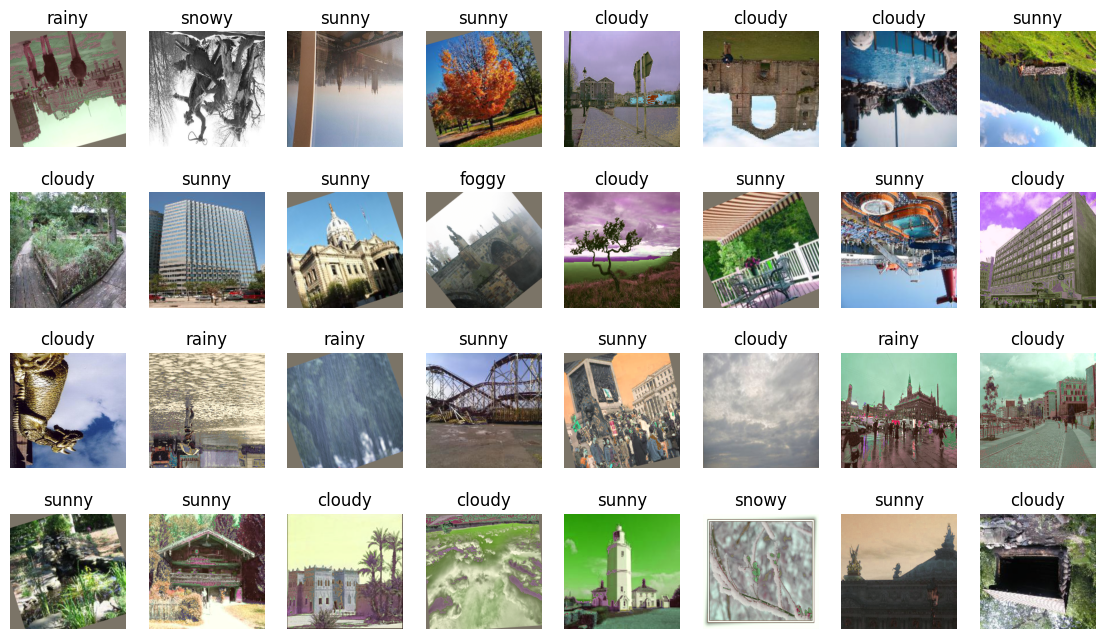

In [ ]:
mydata.showimg()

### model 설정 

In [ ]:
# https://github.com/pytorch/vision/tree/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models
model = models.resnet50(weights=True)

for parameter in model.parameters():
    parameter.requires_grad = False 
for parameter in model.fc.parameters(): # classifier bolck: fc
    parameter.requires_grad = True 
model.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512,5))
model.fc

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth

100%|██████████| 97.8M/97.8M [00:00<00:00, 263MB/s]


Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=5, bias=True)
)

# resnet152, lr=0.001, batch_s=32, scheduler=cosine(50)

In [ ]:
lr = 0.001; patience = 7; epochs = 55
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

myNN = train(model, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN.train_loop()
myNN.result_plot()
# myNN.check(unsq=True, rnd_idx=10)
myNN.evaluation(myNN.model, myNN.testloader, myNN.loss_fn)
torch.save(myNN.model.state_dict(), 'last_checkpoint.pth')
myNN.load_model(dirct='last_checkpoint.pth', model=model)
myNN.load_model(dirct='best_checkpoint.pth', model=model)

# resnet50, lr=0.001, batch_s=16, scheduler=cosine(10)

Epoch : 1/55....... Train Loss : 0.669 Valid Loss : 0.498 Valid Accuracy : 0.806


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.

  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch : 2/55....... Train Loss : 0.534 Valid Loss : 0.471 Valid Accuracy : 0.807

Epoch : 3/55....... Train Loss : 0.497 Valid Loss : 0.466 Valid Accuracy : 0.806

Epoch : 4/55....... Train Loss : 0.463 Valid Loss : 0.451 Valid Accuracy : 0.799

Epoch : 5/55....... Train Loss : 0.445 Valid Loss : 0.454 Valid Accuracy : 0.815

Epoch : 6/55....... Train Loss : 0.432 Valid Loss : 0.414 Valid Accuracy : 0.836

Epoch : 7/55....... Train Loss : 0.417 Valid Loss : 0.413 Valid Accuracy : 0.831

Epoch : 8/55....... Train Loss : 0.408 Valid Loss : 0.437 Valid Accuracy : 0.819

Epoch : 9/55....... Train Loss : 0.397 Valid Loss : 0.409 Valid Accuracy : 0.831

Epoch : 10/55....... Train Loss : 0.383 Valid Loss : 0.435 Valid Accuracy : 0.826

Epoch : 11/55....... Train Loss : 0.372 Valid Loss : 0.446 Valid Accuracy : 0.824

Epoch : 12/55....... Train Loss : 0.354 Valid Loss : 0.416 Valid Accuracy : 0.836

Epoch : 13/55....... Train Loss : 0.355 Valid Loss : 0.409 Valid Accuracy : 0.842

Epoch : 14/5

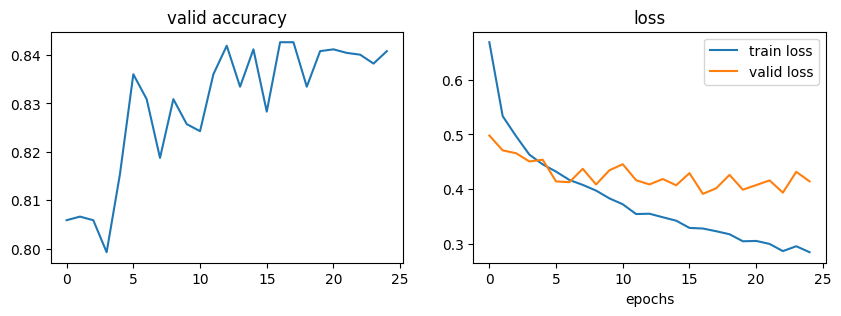

test loss: 0.412

test accuracy: 0.846

test loss: 0.416

test accuracy: 0.839

test loss: 0.405

test accuracy: 0.843


In [ ]:
model = models.resnet152(weights=True)
for parameter in model.parameters():
    parameter.requires_grad = False 
for parameter in model.fc.parameters():
    parameter.requires_grad = True 
model.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512,5))
lr = 0.001; patience = 7; epochs = 55
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
myNN = train(model, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN.train_loop()
myNN.result_plot()
# myNN.check(unsq=True, rnd_idx=10)
myNN.evaluation(myNN.model, myNN.testloader, myNN.loss_fn)
torch.save(myNN.model.state_dict(), 'last_checkpoint.pth')
myNN.load_model(dirct='last_checkpoint.pth', model=model)
myNN.load_model(dirct='best_checkpoint.pth', model=model)

# resnet50, lr=0.001, batch_s=32, scheduler=cosinerestart

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth

100%|██████████| 230M/230M [00:01<00:00, 160MB/s]


Epoch : 1/55....... Train Loss : 0.672 Valid Loss : 0.547 Valid Accuracy : 0.775

Epoch : 2/55....... Train Loss : 0.538 Valid Loss : 0.548 Valid Accuracy : 0.778

Epoch : 3/55....... Train Loss : 0.503 Valid Loss : 0.459 Valid Accuracy : 0.813

Epoch : 4/55....... Train Loss : 0.462 Valid Loss : 0.476 Valid Accuracy : 0.808

Epoch : 5/55....... Train Loss : 0.453 Valid Loss : 0.431 Valid Accuracy : 0.823

Epoch : 6/55....... Train Loss : 0.438 Valid Loss : 0.423 Valid Accuracy : 0.829

Epoch : 7/55....... Train Loss : 0.415 Valid Loss : 0.438 Valid Accuracy : 0.826

Epoch : 8/55....... Train Loss : 0.400 Valid Loss : 0.419 Valid Accuracy : 0.832

Epoch : 9/55....... Train Loss : 0.391 Valid Loss : 0.402 Valid Accuracy : 0.836

Epoch : 10/55....... Train Loss : 0.381 Valid Loss : 0.495 Valid Accuracy : 0.804

Epoch : 11/55....... Train Loss : 0.365 Valid Loss : 0.397 Valid Accuracy : 0.840

Epoch : 12/55....... Train Loss : 0.355 Valid Loss : 0.425 Valid Accuracy : 0.833

Epoch : 13/55

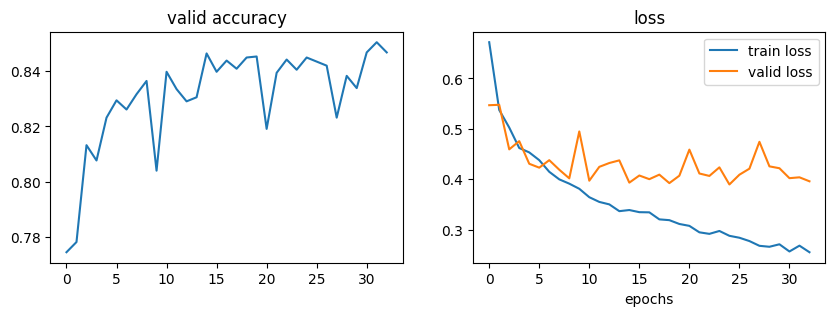

test loss: 0.420

test accuracy: 0.847

test loss: 0.421

test accuracy: 0.847

test loss: 0.428

test accuracy: 0.850


In [ ]:
model2 = models.resnet152(weights=True)
for parameter in model2.parameters():
    parameter.requires_grad = False 
for parameter in model2.fc.parameters():
    parameter.requires_grad = True 
model2.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512,5))
lr = 0.001; patience = 7; epochs = 55
model2 = model2.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model2.parameters(), lr=lr) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, 
                                                                 T_mult=1, eta_min=0.00001)
myNN2 = train(model2, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN2.train_loop()
myNN2.result_plot()
# myNN2.check(unsq=True, rnd_idx=10)
myNN2.evaluation(myNN2.model, myNN2.testloader, myNN2.loss_fn)
torch.save(myNN2.model.state_dict(), 'last_checkpoint.pth')
myNN2.load_model(dirct='last_checkpoint.pth', model=model2)
myNN2.load_model(dirct='best_checkpoint.pth', model=model2)

# resnet50, lr=0.001, batch_s=32, scheduler=stepLR

Epoch : 1/55....... Train Loss : 0.677 Valid Loss : 0.558 Valid Accuracy : 0.771


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.

  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch : 2/55....... Train Loss : 0.541 Valid Loss : 0.485 Valid Accuracy : 0.805

Epoch : 3/55....... Train Loss : 0.498 Valid Loss : 0.448 Valid Accuracy : 0.821

Epoch : 4/55....... Train Loss : 0.464 Valid Loss : 0.454 Valid Accuracy : 0.815

Epoch : 5/55....... Train Loss : 0.439 Valid Loss : 0.422 Valid Accuracy : 0.830

Epoch : 6/55....... Train Loss : 0.432 Valid Loss : 0.405 Valid Accuracy : 0.839

Epoch : 7/55....... Train Loss : 0.408 Valid Loss : 0.429 Valid Accuracy : 0.832

Epoch : 8/55....... Train Loss : 0.399 Valid Loss : 0.436 Valid Accuracy : 0.829

Epoch : 9/55....... Train Loss : 0.393 Valid Loss : 0.497 Valid Accuracy : 0.797

Epoch : 10/55....... Train Loss : 0.379 Valid Loss : 0.430 Valid Accuracy : 0.829

Epoch : 11/55....... Train Loss : 0.370 Valid Loss : 0.415 Valid Accuracy : 0.834

Epoch : 12/55....... Train Loss : 0.359 Valid Loss : 0.454 Valid Accuracy : 0.822

Epoch : 13/55....... Train Loss : 0.357 Valid Loss : 0.426 Valid Accuracy : 0.834

Epoch : 14/5

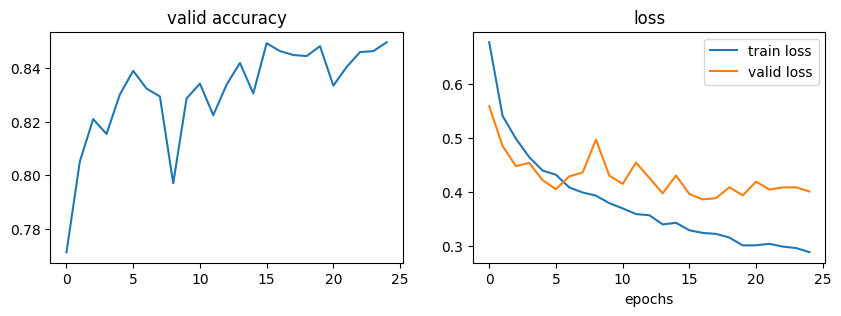

test loss: 0.397

test accuracy: 0.854

test loss: 0.401

test accuracy: 0.849

test loss: 0.413

test accuracy: 0.840


In [ ]:
model3 = models.resnet152(weights=True)
for parameter in model3.parameters():
    parameter.requires_grad = False 
for parameter in model3.fc.parameters():
    parameter.requires_grad = True 
model3.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512,5))
lr = 0.001; patience = 7; epochs = 55
model3 = model3.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model3.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

myNN3 = train(model3, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN3.train_loop()
myNN3.result_plot()
# myNN3.check(unsq=True, rnd_idx=10)
myNN3.evaluation(myNN3.model, myNN3.testloader, myNN3.loss_fn)
torch.save(myNN3.model.state_dict(), 'last_checkpoint.pth')
myNN3.load_model(dirct='last_checkpoint.pth', model=model3)
myNN3.load_model(dirct='best_checkpoint.pth', model=model3)

# resnet50, lr=0.001, batch_s=32, scheduler=multistepLR

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth

100%|██████████| 230M/230M [00:01<00:00, 135MB/s]


Epoch : 1/55....... Train Loss : 0.661 Valid Loss : 0.544 Valid Accuracy : 0.787


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.

  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch : 2/55....... Train Loss : 0.537 Valid Loss : 0.557 Valid Accuracy : 0.771

Epoch : 3/55....... Train Loss : 0.488 Valid Loss : 0.455 Valid Accuracy : 0.819

Epoch : 4/55....... Train Loss : 0.463 Valid Loss : 0.456 Valid Accuracy : 0.812

Epoch : 5/55....... Train Loss : 0.449 Valid Loss : 0.478 Valid Accuracy : 0.804

Epoch : 6/55....... Train Loss : 0.443 Valid Loss : 0.445 Valid Accuracy : 0.823

Epoch : 7/55....... Train Loss : 0.404 Valid Loss : 0.420 Valid Accuracy : 0.838

Epoch : 8/55....... Train Loss : 0.407 Valid Loss : 0.426 Valid Accuracy : 0.826

Epoch : 9/55....... Train Loss : 0.384 Valid Loss : 0.411 Valid Accuracy : 0.835

Epoch : 10/55....... Train Loss : 0.376 Valid Loss : 0.402 Valid Accuracy : 0.832

Epoch : 11/55....... Train Loss : 0.367 Valid Loss : 0.423 Valid Accuracy : 0.830

Epoch : 12/55....... Train Loss : 0.361 Valid Loss : 0.469 Valid Accuracy : 0.818

Epoch : 13/55....... Train Loss : 0.356 Valid Loss : 0.413 Valid Accuracy : 0.844

Epoch : 14/5

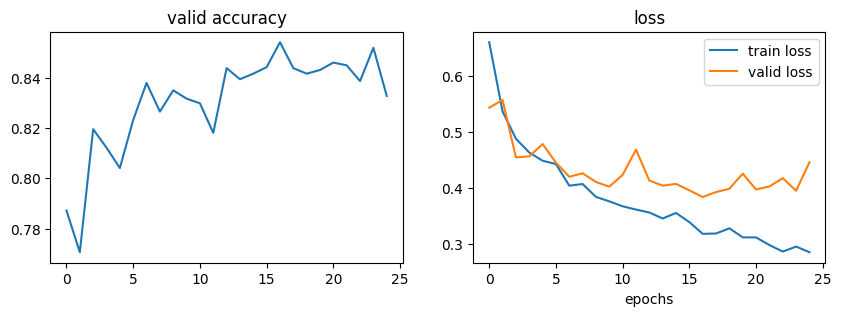

test loss: 0.468

test accuracy: 0.826

test loss: 0.440

test accuracy: 0.833

test loss: 0.399

test accuracy: 0.847


In [ ]:
model4 = models.resnet152(weights=True)
for parameter in model4.parameters():
    parameter.requires_grad = False 
for parameter in model4.fc.parameters():
    parameter.requires_grad = True 
model4.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512,5))
lr = 0.001; patience = 7; epochs = 55
model4 = model4.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model4.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,15,21], gamma=0.5)

myNN4 = train(model4, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN4.train_loop()
myNN4.result_plot()
# myNN4.check(unsq=True, rnd_idx=10)
myNN4.evaluation(myNN4.model, myNN4.testloader, myNN4.loss_fn)
torch.save(myNN4.model.state_dict(), 'last_checkpoint.pth')
myNN4.load_model(dirct='last_checkpoint.pth', model=model4)
myNN4.load_model(dirct='best_checkpoint.pth', model=model4)

# resnet50, lr=0.0001, batch_s=32, scheduler=multistepLR

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth

100%|██████████| 230M/230M [00:04<00:00, 52.5MB/s]


Epoch : 1/55....... Train Loss : 0.757 Valid Loss : 0.563 Valid Accuracy : 0.775


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.

  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch : 2/55....... Train Loss : 0.568 Valid Loss : 0.523 Valid Accuracy : 0.785

Epoch : 3/55....... Train Loss : 0.510 Valid Loss : 0.483 Valid Accuracy : 0.811

Epoch : 4/55....... Train Loss : 0.480 Valid Loss : 0.460 Valid Accuracy : 0.815

Epoch : 5/55....... Train Loss : 0.453 Valid Loss : 0.423 Valid Accuracy : 0.831

Epoch : 6/55....... Train Loss : 0.433 Valid Loss : 0.425 Valid Accuracy : 0.831

Epoch : 7/55....... Train Loss : 0.420 Valid Loss : 0.415 Valid Accuracy : 0.828

Epoch : 8/55....... Train Loss : 0.410 Valid Loss : 0.431 Valid Accuracy : 0.828

Epoch : 9/55....... Train Loss : 0.400 Valid Loss : 0.400 Valid Accuracy : 0.842

Epoch : 10/55....... Train Loss : 0.383 Valid Loss : 0.405 Valid Accuracy : 0.839

Epoch : 11/55....... Train Loss : 0.372 Valid Loss : 0.402 Valid Accuracy : 0.838

Epoch : 12/55....... Train Loss : 0.365 Valid Loss : 0.388 Valid Accuracy : 0.840

Epoch : 13/55....... Train Loss : 0.358 Valid Loss : 0.460 Valid Accuracy : 0.814

Epoch : 14/5

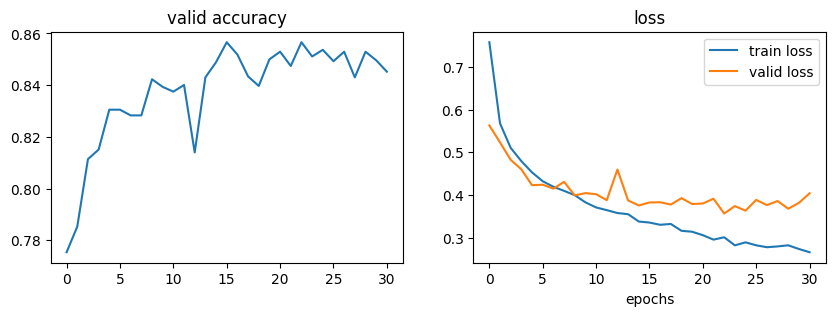

test loss: 0.395

test accuracy: 0.845

test loss: 0.414

test accuracy: 0.842

test loss: 0.381

test accuracy: 0.857


In [ ]:
model5 = models.resnet152(weights=True)
for parameter in model5.parameters():
    parameter.requires_grad = False 
for parameter in model5.fc.parameters():
    parameter.requires_grad = True 
model5.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512,5))
lr = 0.0001; patience = 7; epochs = 55
model5 = model5.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model5.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,15,21], gamma=0.5)

myNN4 = train(model5, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN4.train_loop()
myNN4.result_plot()
# myNN4.check(unsq=True, rnd_idx=10)
myNN4.evaluation(myNN4.model, myNN4.testloader, myNN4.loss_fn)
torch.save(myNN4.model.state_dict(), 'last_checkpoint.pth')
myNN4.load_model(dirct='last_checkpoint.pth', model=model5)
myNN4.load_model(dirct='best_checkpoint.pth', model=model5)

In [ ]:
9

# resnet50, lr=0.001, batch_s=32, scheduler=ReducedLR

Epoch : 1/55....... Train Loss : 0.701 Valid Loss : 0.576 Valid Accuracy : 0.761

Epoch : 2/55....... Train Loss : 0.560 Valid Loss : 0.514 Valid Accuracy : 0.790

Epoch : 3/55....... Train Loss : 0.503 Valid Loss : 0.503 Valid Accuracy : 0.786

Epoch : 4/55....... Train Loss : 0.483 Valid Loss : 0.464 Valid Accuracy : 0.809

Epoch : 5/55....... Train Loss : 0.463 Valid Loss : 0.493 Valid Accuracy : 0.809

Epoch : 6/55....... Train Loss : 0.443 Valid Loss : 0.452 Valid Accuracy : 0.825

Epoch : 7/55....... Train Loss : 0.425 Valid Loss : 0.470 Valid Accuracy : 0.810

Epoch : 8/55....... Train Loss : 0.402 Valid Loss : 0.480 Valid Accuracy : 0.816

Epoch : 9/55....... Train Loss : 0.398 Valid Loss : 0.459 Valid Accuracy : 0.823

Epoch : 10/55....... Train Loss : 0.393 Valid Loss : 0.426 Valid Accuracy : 0.833

Epoch : 11/55....... Train Loss : 0.377 Valid Loss : 0.452 Valid Accuracy : 0.824

Epoch : 12/55....... Train Loss : 0.366 Valid Loss : 0.464 Valid Accuracy : 0.824

Epoch : 13/55

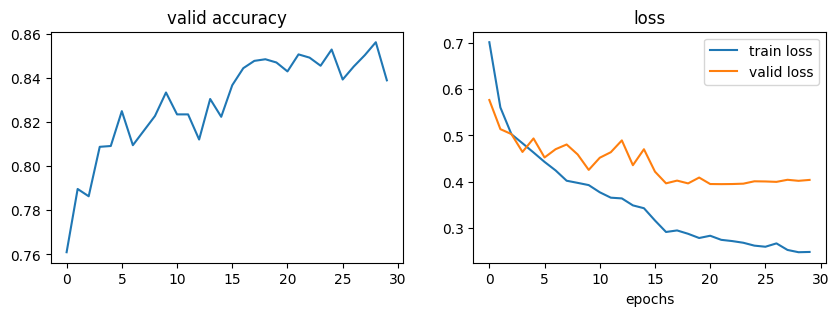

test loss: 0.368

test accuracy: 0.862

test loss: 0.388

test accuracy: 0.854

test loss: 0.380

test accuracy: 0.858


In [ ]:
model6 = models.resnet50(weights=True)
for parameter in model6.parameters():
    parameter.requires_grad = False 
for parameter in model6.fc.parameters():
    parameter.requires_grad = True 
model6.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512,5))
lr = 0.001; patience = 7; epochs = 55
model6 = model6.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model6.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

myNN4 = train(model6, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN4.train_loop()
myNN4.result_plot()
# myNN4.check(unsq=True, rnd_idx=10)
myNN4.evaluation(myNN4.model, myNN4.testloader, myNN4.loss_fn)
torch.save(myNN4.model.state_dict(), 'last_checkpoint.pth')
myNN4.load_model(dirct='last_checkpoint.pth', model=model6)
myNN4.load_model(dirct='best_checkpoint.pth', model=model6)

# resnet50, lr=0.001, batch_s=32, scheduler=ReducedLR, compose = Colorjitter

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch : 1/55....... Train Loss : 0.888 Valid Loss : 0.789 Valid Accuracy : 0.670

Epoch : 2/55....... Train Loss : 0.769 Valid Loss : 0.745 Valid Accuracy : 0.702

Epoch : 3/55....... Train Loss : 0.743 Valid Loss : 0.708 Valid Accuracy : 0.715

Epoch : 4/55....... Train Loss : 0.723 Valid Loss : 0.664 Valid Accuracy : 0.726

Epoch : 5/55....... Train Loss : 0.692 Valid Loss : 0.668 Valid Accuracy : 0.731

Epoch : 6/55....... Train Loss : 0.687 Valid Loss : 0.672 Valid Accuracy : 0.722

Epoch : 7/55....... Train Loss : 0.674 Valid Loss : 0.660 Valid Accuracy : 0.722

Epoch : 8/55....... Train Loss : 0.655 Valid Loss : 0.650 Valid Accuracy : 0.740

Epoch : 9/55....... Train Loss : 0.649 Valid Loss : 0.659 Valid Accuracy : 0.730

Epoch : 10/55....... Train Loss : 0.640 Valid Loss : 0.650 Valid Accuracy : 0.746

Epoch : 11/55....... Train Loss : 0.640 Valid Loss : 0.662 Valid Accuracy : 0.735

Epoch : 12/55....... Train Loss : 0.629 Valid Loss : 0.618 Valid Accuracy : 0.747

Epoch : 13/55

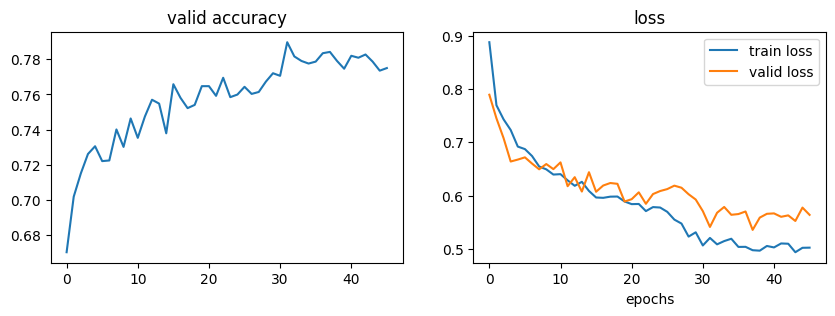

test loss: 0.557

test accuracy: 0.779

test loss: 0.547

test accuracy: 0.783

test loss: 0.548

test accuracy: 0.783


In [ ]:
model7 = models.resnet50(weights=True)
for parameter in model7.parameters():
    parameter.requires_grad = False 
for parameter in model7.fc.parameters():
    parameter.requires_grad = True 
model7.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512,5))
lr = 0.001; patience = 7; epochs = 55
model7 = model7.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model7.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

myNN4 = train(model7, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN4.train_loop()
myNN4.result_plot()
# myNN4.check(unsq=True, rnd_idx=10)
myNN4.evaluation(myNN4.model, myNN4.testloader, myNN4.loss_fn)
torch.save(myNN4.model.state_dict(), 'last_checkpoint.pth')
myNN4.load_model(dirct='last_checkpoint.pth', model=model7)
myNN4.load_model(dirct='best_checkpoint.pth', model=model7)

# resnet50, lr=0.001, batch_s=32, scheduler=ReducedLR, compose = Colorjitter (hue = 0.8)

In [ ]:
model7 = models.resnet50(weights=True)
for parameter in model7.parameters():
    parameter.requires_grad = False 
for parameter in model7.fc.parameters():
    parameter.requires_grad = True 
model7.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512,5))
lr = 0.001; patience = 7; epochs = 55
model7 = model7.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model7.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

myNN4 = train(model7, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN4.train_loop()
myNN4.result_plot()
# myNN4.check(unsq=True, rnd_idx=10)
myNN4.evaluation(myNN4.model, myNN4.testloader, myNN4.loss_fn)
torch.save(myNN4.model.state_dict(), 'last_checkpoint.pth')
myNN4.load_model(dirct='last_checkpoint.pth', model=model7)
myNN4.load_model(dirct='best_checkpoint.pth', model=model7)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch : 1/55....... Train Loss : 0.801 Valid Loss : 0.698 Valid Accuracy : 0.711

Epoch : 2/55....... Train Loss : 0.674 Valid Loss : 0.636 Valid Accuracy : 0.741

Epoch : 3/55....... Train Loss : 0.636 Valid Loss : 0.643 Valid Accuracy : 0.731

Epoch : 4/55....... Train Loss : 0.598 Valid Loss : 0.593 Valid Accuracy : 0.757

Epoch : 5/55....... Train Loss : 0.583 Valid Loss : 0.553 Valid Accuracy : 0.769

Epoch : 6/55....... Train Loss : 0.568 Valid Loss : 0.564 Valid Accuracy : 0.770

Epoch : 7/55....... Train Loss : 0.547 Valid Loss : 0.558 Valid Accuracy : 0.779

Epoch : 8/55....... Train Loss : 0.549 Valid Loss : 0.564 Valid Accuracy : 0.779


In [ ]:
class mySplitFP():
    def __init__(self, root, labels_map):
        self.root, self.labels_map = root, labels_map
        self.dfs = None
        
    def __call__(self):
        return self.split_join_dfs()
        
    def create_dfs(self):
        cloudy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[0]+'/*.*'), 'label':0})
        foggy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[1]+'/*.*'), 'label':1})
        rainy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[2]+'/*.*'), 'label':2})
        snowy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[3]+'/*.*'), 'label':3})
        sunny_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[4]+'/*.*'), 'label':4})
        self.dfs = [cloudy_df, foggy_df, rainy_df, snowy_df, sunny_df]
        
    def split_join_dfs(self, train_p=0.65, valid_p=0.15, test_p=0.2):
        self.create_dfs()
        idxs_dict = {'train':[], 'valid':[], 'test':[]}
        for df in self.dfs:
            train_n, valid_n = len(df)//(1/train_p), len(df)//(1/valid_p)
            df['cut'] = pd.cut(df.index, bins=[-np.inf, train_n, train_n+valid_n, np.inf], labels=['train','valid','test'])
            for k in idxs_dict.keys():
                idxs_dict[k].append(df.loc[df['cut']==k, ['filepath','label']])
        for k,v in idxs_dict.items():
            if k=='train': train_df = pd.concat(v, axis=0).reset_index()
            elif k=='valid': valid_df = pd.concat(v, axis=0).reset_index()
            elif k=='test': test_df = pd.concat(v, axis=0).reset_index()
        return train_df, valid_df, test_df
    
    def split_join_dfs_fail(self):
        self.create_dfs()
        idxs_dict = {'train':[], 'valid':[], 'test':[]}
        for df in self.dfs:
            train_idxs, test_idxs = train_test_split(df.index, test_size=0.2, shuffle=True)
            train_idxs, valid_idxs = train_test_split(train_idxs, test_size=0.2, shuffle=True)
            for k,idxs in zip(idxs_dict.keys(),[train_idxs,valid_idxs,test_idxs]):
                idxs_dict[k].append(idxs)
        for k in idxs_dict.keys():
            each_dfs = [self.dfs[i].iloc[idxs_dict[k][i]] for i in range(len(self.dfs))]
            if k=='train': train_df = pd.concat(each_dfs, axis=0).reset_index()
            elif k=='valid': valid_df = pd.concat(each_dfs, axis=0).reset_index()
            elif k=='test': test_df = pd.concat(each_dfs, axis=0).reset_index()
        return train_df, valid_df, test_df
    
class mycreateDataset(Dataset):
    def __init__(self, df, transform, using='transforms'):
        self.filepaths = df['filepath'].values
        self.labels = df['label'].values
        self.transform = transform
        self.using = using

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_filepath = self.filepaths[idx]
        img = Image.open(img_filepath).convert('RGB')
        if self.using=='A': 
            img = np.array(img)
            transformed_img = self.transform(image=img)['image']
        else: 
            transformed_img = self.transform(img)
        return transformed_img, self.labels[idx]

class mysetting():
    def __init__(self, root, labels_map):
        self.labels_map = labels_map
        self.train_df, self.valid_df, self.test_df = mySplitFP(root, labels_map).__call__()
        
    def getDataset(self, transform, using='transforms'):
        self.trainset = mycreateDataset(self.train_df, transform, using)
        self.validset = mycreateDataset(self.valid_df, transform, using)
        self.testset = mycreateDataset(self.test_df, transform, using)
        print('train, valid, test:', len(self.trainset), len(self.validset), len(self.testset))
        return self
    
    def getDataloader(self, batch_s=16):
        self.trainloader = DataLoader(self.trainset, batch_size=batch_s, shuffle=True)
        self.validloader = DataLoader(self.validset, batch_size=batch_s, shuffle=True)
        self.testloader = DataLoader(self.testset, batch_size=batch_s, shuffle=True)
        print('train, valid, test:', len(self.trainloader), len(self.validloader), len(self.testloader))
        train_iter = iter(self.trainloader)
        imgs, labels = train_iter.__next__()
        print('trainloader shape', imgs.shape, labels.shape)
        return self
    
    def showimg(self):
        fig, ax = plt.subplots(4,8, figsize=(14,8))
        ax = ax.flatten()
        for i in range(32):
            item = self.trainset[np.random.randint(0, len(self.trainset))]
            img, label = item[0].permute(1,2,0), item[1]
            img.mul_(torch.tensor([0.229, 0.224, 0.225])) # std
            img.add_(torch.tensor([0.485, 0.456, 0.406])) # mean
            ax[i].axis('off'); ax[i].imshow(img)
            ax[i].set_title(self.labels_map[label])

In [ ]:
class train():
    def __init__(self, model, loss_fn, optimizer, trainloader, validloader, testloader, 
                 scheduler, device, epochs=30, patience=5, batch_s=16, reg=False,
                 cnn=True, resize=784):
        self.model, self.loss_fn, self.optimizer = model, loss_fn, optimizer
        self.trainloader, self.validloader, self.testloader = trainloader, validloader, testloader
        self.scheduler, self.device = scheduler, device
        self.epochs, self.patience, self.batch_s = epochs, patience, batch_s
        self.reg = reg
        self.cnn, self.resize = cnn, resize
        self.train_loss_li, self.valid_loss_li, self.valid_acc_li = [], [], []
        
    def train_loop(self):
        min_loss = 2000; trigger = 0
        train_loss_li, valid_loss_li, valid_acc_li = [], [], []
        for epoch in range(self.epochs):
            self.model.train() # 훈련모드
            train_loss = 0
            for imgs, labels in self.trainloader:
                if self.cnn:
                    imgs, labels = imgs.to(self.device), labels.to(self.device)
                else:
                    imgs.resize_(imgs.shape[0], self.resize)
                loss = self.loss_fn(self.model(imgs), labels) 
                self.optimizer.zero_grad() 
                loss.backward() 
                self.optimizer.step() 
                train_loss += loss.item()

            self.model.eval() # 평가 모드
            valid_loss, valid_accuracy = self.evaluate(valid=True)

            if not self.reg: print('Epoch : {}/{}.......'.format(epoch+1, self.epochs),            
                  'Train Loss : {:.3f}'.format(train_loss/len(self.trainloader)), 
                  'Valid Loss : {:.3f}'.format(valid_loss), 
                  'Valid Accuracy : {:.3f}'.format(valid_accuracy))
            else: print('Epoch : {}/{}.......'.format(epoch+1, self.epochs),            
                  'Train Loss : {:.3f}'.format(train_loss/len(self.trainloader)), 
                  'Valid Loss : {:.3f}'.format(valid_loss))
            train_loss_li.append(train_loss/len(self.trainloader))
            valid_loss_li.append(valid_loss)
            valid_acc_li.append(valid_accuracy)

            if valid_loss > min_loss: # early stop
                trigger += 1
                if trigger > self.patience:
                    print('\nEarly Stopping!! epoch/epochs: {}/{}'.format(epoch, self.epochs))
                    break
            else:
                trigger = 0
                min_loss = valid_loss # min_loss 갱신
                best_model_state = deepcopy(self.model.state_dict())
                torch.save(best_model_state, 'best_checkpoint.pth') # valid loss가 커지기 전의 모델 저장

            self.scheduler.step(valid_loss) # learning rate scheduler
        self.train_loss_li, self.valid_loss_li, self.valid_acc_li = train_loss_li, valid_loss_li, valid_acc_li
        return

    def result_plot(self):
        fig, ax = plt.subplots(1,2, figsize=(10,3))
        x = np.arange(len(self.valid_acc_li))
        ax[0].plot(x, self.valid_acc_li, label='valid_accuracy')
        ax[0].set_title('valid accuracy')
        ax[1].plot(x, self.train_loss_li, label='train loss')
        ax[1].plot(x, self.valid_loss_li, label='valid loss')
        ax[1].set_title('loss')
        plt.xlabel('epochs'); plt.legend(loc='best')
        plt.show()

    def evaluate(self, valid=False):
        if valid: load = self.validloader
        else: load = self.testloader
            
        loss, accuracy = 0, 0
        with torch.no_grad():
            for imgs, labels in load:
                if self.cnn:
                    imgs, labels = imgs.to(self.device), labels.to(self.device)
                else:
                    imgs.resize_(imgs.size()[0], self.resize)
                logit = self.model(imgs)
                _, preds = torch.max(logit, 1)
                loss += self.loss_fn(logit, labels).item()
                accuracy += int((preds==labels).sum())
        return loss/len(load), accuracy/(self.batch_s*len(load))
    
    def check(self, unsq=True, rnd_idx=10):
        test_iter = iter(self.testloader)
        imgs, labels = next(test_iter)
        print(imgs.size(), labels.size())
        print(imgs[rnd_idx].shape, labels[rnd_idx])
        self.model.eval()
        with torch.no_grad():
            if unsq:
                logit = self.model(imgs[rnd_idx].unsqueeze(0))
            else:
                logit = self.model(imgs[rnd_idx].view(1, self.resize))
        pred = logit.max(dim=1)[1]
        print(pred==labels[rnd_idx])
        
    def evaluation(self, model, testloader, loss_fn):
        loss, accuracy = 0, 0
        with torch.no_grad():
            for imgs, labels in testloader:
                if self.cnn:
                    imgs, labels = imgs.to(self.device), labels.to(self.device)
                else:
                    imgs.resize_(imgs.size()[0], self.resize)
                logit = model(imgs)
                _, preds = torch.max(logit, 1)
                loss += loss_fn(logit, labels).item()
                accuracy += int((preds==labels).sum())
        print('test loss: {:.3f}\ntest accuracy: {:.3f}'.format(loss/len(testloader), accuracy/(self.batch_s*len(testloader))))

    def load_model(self, dirct, model):
        state_dict = torch.load(dirct)
        load_model = model
        load_model.load_state_dict(state_dict)
        load_model.eval()
        self.evaluation(load_model, self.testloader, self.loss_fn)